In [1]:
# update dwave packages
!python -m pip install -U dimod dwave-ocean-sdk dwave-neal

     |████████████████████████████████| 13.2 MB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 497 kB 66.3 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 97 kB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.0 MB 45.9 MB/s eta 0:00:01
     |████████████████████████████████| 12.3 MB 38.2 MB/s eta 0:00:01
     |████████████████████████████████| 107 kB 74.0 MB/s eta 0:00:01
     |████████████████████████████████| 271 kB 67.7 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 8.2 MB/s  eta 0:00:01
     |████████████████████████████████| 229 kB 68.7 MB/s eta 0:00:01
     |████████████████████████████████| 696 kB 62.9 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 9.1 MB/s  eta 0:00:01
     |████████████████████████████████| 935 kB 42.1 MB/s eta 0:00:01
     |████████████████████████████████| 655 kB 42.3 MB/s eta 0:00:01
     |██████████████████████████████

  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.4
    Uninstalling pyparsing-3.0.4:
      Successfully uninstalled pyparsing-3.0.4
  Attempting uninstall: dimod
    Found existing installation: dimod 0.9.13
    Uninstalling dimod-0.9.13:
      Successfully uninstalled dimod-0.9.13
  Attempting uninstall: dwave-networkx
    Found existing installation: dwave-networkx 0.8.8
    Uninstalling dwave-networkx-0.8.8:
      Successfully uninstalled dwave-networkx-0.8.8
  Attempting uninstall: penaltymodel
    Found existing installation: penaltymodel 0.16.4
    Uninstalling penaltymodel-0.16.4:
      Successfully uninstalled penaltymodel-0.16.4
  Attempting uninstall: minorminer
    Found existing installation: minorminer 0.2.5
    Uninstalling minorminer-0.2.5:
      Successfully uninstalled minorminer-0.2.5
  Attempting uninstall: dwave-tabu
    Found existing installation: dwave-tabu 0.3.1
    Uninstalling dwave-tabu-0.3.1:
      Successfully uninstalled dwa

In [2]:
# imports 

from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
from dwave.system import LeapHybridSampler
# from dwave.system import FixedEmbeddingComposite

from dwave.system.composites import EmbeddingComposite
from dwave.system import FixedEmbeddingComposite, LazyFixedEmbeddingComposite
from dimod import BQM

from dimod.binary_quadratic_model import BinaryQuadraticModel
import dimod
import time
import re
import matplotlib.pyplot as plt
import pandas as pd
import json


# Run experiment for DW 2000Q QPU

Custom choise of EmbeddingComposite. The choise of embedding does not affect solution greatly for this simple games. Further investigation is needed for larger number of playesr/strategies.

In [3]:
device  = AwsDevice('.../DW_2000Q_6')
device

Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)

In [4]:
# Constracting BQM for the 2 strategies game

Q = {('p1', 'q1'):-3, ('p1', 'q2'):2, ('p2', 'q2'):-3}
bqm = BinaryQuadraticModel(Q, vartype='BINARY')

# add constraints

bqm.add_linear_equality_constraint([('p1',1), ('p2', 1)], constant=-1, lagrange_multiplier=1)
bqm.add_linear_equality_constraint([('q1',1), ('q2', 1)],  constant=-1, lagrange_multiplier=1)
bqm.add_linear_inequality_constraint([('q1', 2), ('q2', -1)], lb=-1, ub=2, lagrange_multiplier=1, label = 'constr1')
bqm.add_linear_inequality_constraint([('q1', -1), ('q2', 1)], lb=-1, ub=1, lagrange_multiplier=1, label = 'constr2')
bqm.add_linear_inequality_constraint([('p1', 1), ('p2', -1)], lb=-1, ub=1, lagrange_multiplier=1, label = 'constr3')
bqm.add_linear_inequality_constraint([('p1', 1), ('p2', 2)], lb=-1, ub=2, lagrange_multiplier=1, label = 'constr4')

/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/dimod/binary/binary_quadratic_model.py:707: UserWarning: Did not add constraint constr1. This constraint is feasible with any value for state variables.
  f'Did not add constraint {label}.'
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/dimod/binary/binary_quadratic_model.py:707: UserWarning: Did not add constraint constr2. This constraint is feasible with any value for state variables.
  f'Did not add constraint {label}.'
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/dimod/binary/binary_quadratic_model.py:707: UserWarning: Did not add constraint constr3. This constraint is feasible with any value for state variables.
  f'Did not add constraint {label}.'


[('slack_constr4_0', 1), ('slack_constr4_1', 1)]

In [5]:
def plot_sampleset2(sampleset, num_sample):
    '''Plots results of sampling in a bar style.
        Arg: sampleset: a set of samples prodused by DWave's sampler
             num_sample: the number of samples received from DWave's sampler'''
        
    sampleset = dimod.drop_variables(sampleset, ['slack_constr4_0','slack_constr4_1']  )
    sampleset = sampleset.aggregate()

    df = sampleset.to_pandas_dataframe()

    strategies = {}
    for i, row in df.iterrows():
        strategy = str(df['p1'][i])+str(df['p2'][i])+str(df['q1'][i])+str(df['q2'][i])
        if len((re.findall('1', strategy))) <=2:
            strategies[strategy]=row['num_occurrences']
    
    myList = strategies.items()
    myList = [('p=(' + item[0][:1]+','+ item[0][1:2]+'), q=('+item[0][2:3]+','+ item[0][3:] +')', item[1]) for item in myList]
    myList = sorted(myList) 
    x, y = zip(*myList) 

    plt.bar(x,y, color='Blue')
    plt.title('Frequency of pure NE points based on ' +str(num_sample) + ' samples')
    plt.xlabel('Pure Strategy')
    plt.ylabel('Frequency')
    plt.savefig('Frequency_2strategies.png', dpi=600)
    plt.show()

  
#paste the device arn
emd_comp =  BraketDWaveSampler(device_arn='...DW_2000Q_6')
sampleset2 = EmbeddingComposite(emd_comp).sample(bqm, num_reads=5000)


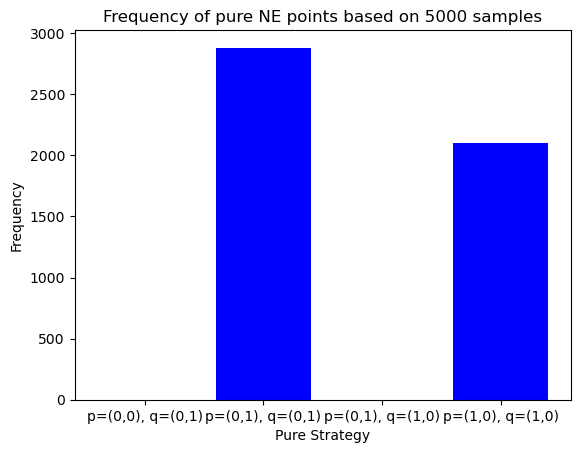

In [6]:
plot_sampleset2(sampleset=sampleset2, num_sample=5000)

In [28]:
def performance(device_arn, num_sample, iter_step):
    '''Samples from DWave's hardware and constracts graph performance.
        Stores the info from sampleset and results of sampling
    Args: num_sample: number of samples from a sampler, [start, end]
          device_arn: AWS devide Arn
          iter_step: step to itterate
    Return: Total time for sampling on QPU.'''
  
    emd_comp =  BraketDWaveSampler(device_arn=device_arn)

    # store in json df the samplesest
    json_storage = {}
    solutions = pd.DataFrame()

    total_runtime = []
    time_inQPU = []
    time_sampling = []
    start = num_sample[0]
    end = num_sample[1]
    
    while start <= end:
        # sample
        sampleset = EmbeddingComposite(emd_comp).sample(bqm, num_reads=start)
        json_storage[start] = sampleset.info
        sampleset.to_pandas_dataframe().to_csv(device_arn[-10:] + 'sampleset.csv', mode='a')
        
        # total time in QPU
        qpu_time = sampleset.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAccessTime']

        qpu_overhead_time = sampleset.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAccessOverheadTime']
        total_postproc = sampleset.info['additionalMetadata']['dwaveMetadata']['timing']['totalPostProcessingTime']
        total_postproc_overhead = sampleset.info['additionalMetadata']['dwaveMetadata']['timing']['postProcessingOverheadTime']

        total_runtime.append(sum([qpu_time, qpu_overhead_time, total_postproc, total_postproc_overhead]))
        time_inQPU.append(qpu_time)
        # time spent to sample n samples.
        time_sampling.append(sampleset.info['additionalMetadata']['dwaveMetadata']['timing']['qpuSamplingTime'])

        start += iter_step
    
    # Writing the info
    file_name = device_arn[-10:] + 'sample_info.json'
    json_file = json.dumps(json_storage)
    with open(file_name, "w") as outfile:
        outfile.write(json_file)
    # Writing the solution sets
    solutions.to_csv(device_arn[-10:]+'sampleset.csv')

    return time_inQPU, time_sampling, total_runtime


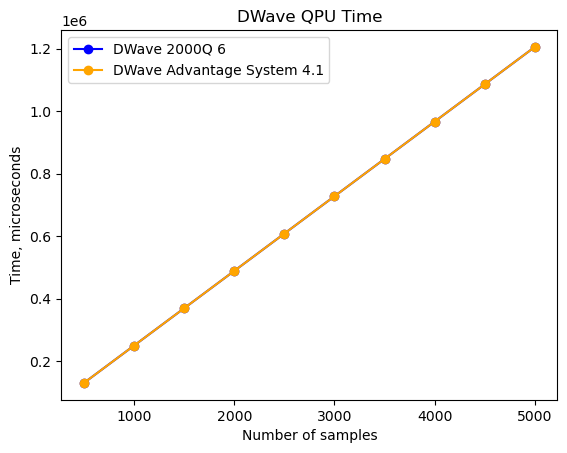

In [19]:
# sampling parameters
start = 500
end= 5001
step = 500

#paste the device arn
time_inQPU2000q, time_sampling2000q, total_runtime2000q = performance(device_arn='.../DW_2000Q_6', num_sample=[start, end], iter_step=step)
time_inQPUadvantage, time_samplingadvantage, total_runtimeadvantage = performance(device_arn='.../Advantage_system4', num_sample=[start, end], iter_step=step)

x = [sample for sample in range(start, end, step) ]



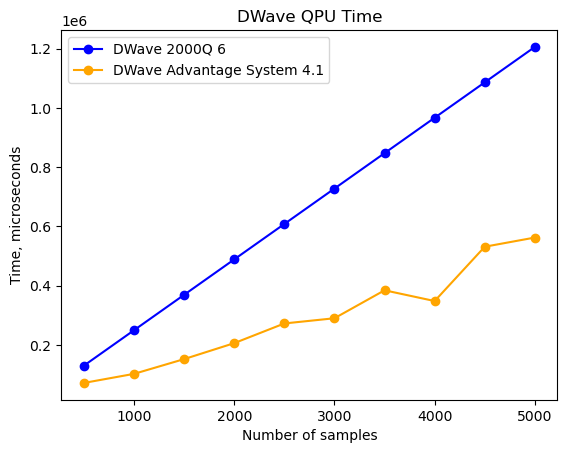

In [20]:
# plot QPU Time
plt.plot(x, time_inQPU2000q, color='blue', marker='o', label='DWave 2000Q 6')
plt.plot(x, time_inQPUadvantage, color='orange', marker='o', label='DWave Advantage System 4.1')
plt.title('DWave QPU Time')
plt.xlabel('Number of samples')
plt.ylabel('Time, microseconds')
plt.legend(loc="upper left")
plt.savefig('QPU_Time_2strategies.png', dpi=600)
# plt.savefig('QPU_Time_3strategies.png', dpi=600)
plt.show()

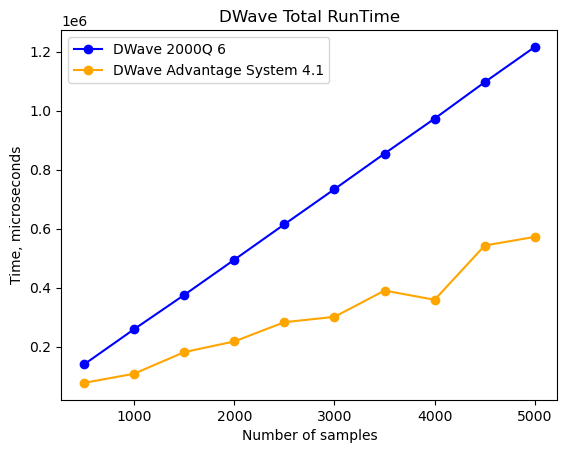

In [21]:
# Plot Total Run time
plt.plot(x, total_runtime2000q, color='blue', marker='o', label='DWave 2000Q 6')
plt.plot(x, total_runtimeadvantage, color='orange', marker='o', label='DWave Advantage System 4.1')
plt.title('DWave Total RunTime')
plt.xlabel('Number of samples')
plt.ylabel('Time, microseconds')
plt.legend(loc="upper left")
plt.savefig('Total_Runtime_2strategies.png', dpi=600)
# plt.savefig('Total_Runtime_3strategies.png', dpi=600)
plt.show()

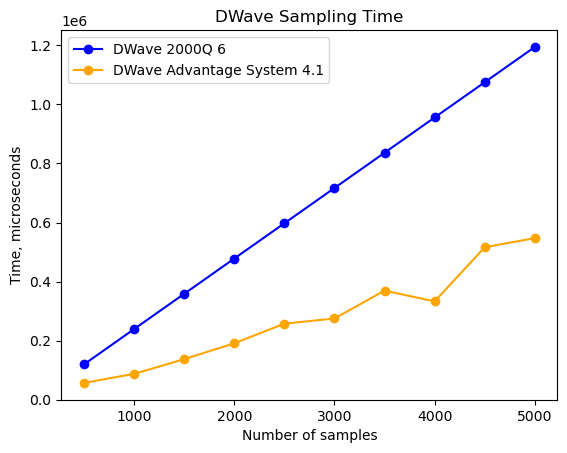

In [22]:
# plot total sampling time

plt.plot(x, time_sampling2000q, color='blue', marker='o', label='DWave 2000Q 6')
plt.plot(x, time_samplingadvantage, color='orange', marker='o', label='DWave Advantage System 4.1')
plt.title('DWave Sampling Time')
plt.xlabel('Number of samples')
plt.ylabel('Time, microseconds')
plt.legend(loc="upper left")
plt.savefig('Sampling_Time_2strategies.png', dpi=600)
# plt.savefig('Sampling_Time_3strategies.png', dpi=600)
plt.show()

# Run experiment for DW Advantage QPU

In [23]:
device = AwsDevice('arn:aws:braket:::device/qpu/d-wave/Advantage_system4')
device

Device('name': Advantage_system4.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system4)

In [23]:
# Constracting BQM for the 3 strategies game
Q = {('p1', 'q1'):10, ('p1', 'q2'):-10, ('p2', 'q2'):-4, ('p2', 'q3'):-7, ('p3', 'q3'):-10}

bqm = BQM(Q, vartype='BINARY')

# constraints on probability
bqm.add_linear_equality_constraint([('p1',1), ('p2', 1), ('p3', 1)], constant=-1, lagrange_multiplier=10)
bqm.add_linear_equality_constraint([('q1',1), ('q2', 1), ('q3', 1)],  constant=-1, lagrange_multiplier=10)

# inequality constraints
# bqm.add_linear_inequality_constraint([('q1', -2), ('q2', 4), ('q3', 1)], lb=-2, ub=4, lagrange_multiplier=1, label = 'constr1')
# bqm.add_linear_inequality_constraint([('q2', 2), ('q3', 1)], lb=1, ub=2, lagrange_multiplier=1, label = 'constr2')
# bqm.add_linear_inequality_constraint([('q1', -5), ('q2', 12), ('q3', 10)], lb=-5, ub=12, lagrange_multiplier=1, label = 'constr3')
# bqm.add_linear_inequality_constraint([('p1', -2), ('p3', -1)], lb=-2, ub=-1, lagrange_multiplier=1, label = 'constr4')
# bqm.add_linear_inequality_constraint([('p1', -5), ('p2', 1), ('p3', 3)], lb=-5, ub=3, lagrange_multiplier=1, label = 'constr5')
# bqm.add_linear_inequality_constraint([('p1', 5), ('p2', 2), ('p3', 10)], lb=2, ub=10, lagrange_multiplier=1, label = 'constr6')


In [21]:
# test before run 
#paste the device arn
emd_comp =  BraketDWaveSampler(device_arn='.../DW_2000Q_6')
sampleset3 = EmbeddingComposite(emd_comp).sample(bqm, num_reads=1000)

print("Best solution found: \n",sampleset3)

Best solution found: 
   p1 p2 p3 q1 q2 q3 energy num_oc. chain_.
0  0  0  1  0  0  1  -10.0     699     0.0
1  1  0  0  0  1  0  -10.0     202     0.0
2  0  1  1  0  0  1   -7.0      54     0.0
3  0  1  0  0  0  1   -7.0      39     0.0
4  0  1  0  0  1  0   -4.0       3     0.0
5  1  1  0  0  1  0   -4.0       1     0.0
6  0  1  0  0  1  1   -1.0       1     0.0
7  0  1  1  0  1  1   -1.0       1     0.0
['BINARY', 8 rows, 1000 samples, 6 variables]


In [24]:
def plot_sampleset3(sampleset, num_sample):
    '''Plots results of sampling in a bar style.
        Arg: sampleset: a set of samples prodused by DWave's sampler
             num_sample: the number of samples received from DWave's sampler'''
    
    slack_const = ['slack_constr1_0', 'slack_constr1_1', 'slack_constr1_2', 'slack_constr1_3', 
                   'slack_constr1_4', 'slack_constr2_0', 'slack_constr2_1', 'slack_constr3_0', 'slack_constr3_1', 
                   'slack_constr3_2', 'slack_constr3_3', 'slack_constr3_4', 'slack_constr4_0', 'slack_constr4_1', 
                   'slack_constr4_2', 'slack_constr6_0', 'slack_constr6_1', 'slack_constr6_2', 'slack_constr6_3']
    sampleset = dimod.drop_variables(sampleset, slack_const)
    sampleset = sampleset.aggregate()

    df = sampleset.to_pandas_dataframe()

    strategies = {}
    for i, row in df.iterrows():
    #     print(row['num_occurrences'])
    #     break
        strategy = str(df['p1'][i])+str(df['p2'][i])+str(df['p3'][i])+str(df['q1'][i]) +str(df['q2'][i])+str(df['q3'][i])
        if len((re.findall('1', strategy))) <=2:
            strategies[strategy]=row['num_occurrences']

    myList = strategies.items()
    myList = [('p=('+item[0][:1]+','+ item[0][1:2]+','+item[0][2:3]+'), q=('+item[0][3:4]+','+ item[0][4:5]+','+ item[0][5:] +')', item[1]) for item in myList]
    myList = sorted(myList) 
    x, y = zip(*myList) 

#     plt.bar(x,y, color='Blue')
    plt.barh(x,y, color='Blue')
    plt.title('Frequency of pure NE points based on ' +str(num_sample) + ' samples')
    plt.xlabel('Frequency')
    plt.ylabel('Pure Strategy')
    plt.savefig('Frequency_3strategies.png', dpi=600)
    plt.show()





In [25]:
#paste the device arn
emd_comp =  BraketDWaveSampler(device_arn='.../DW_2000Q_6')
sampleset3 = EmbeddingComposite(emd_comp).sample(bqm, num_reads=5000)

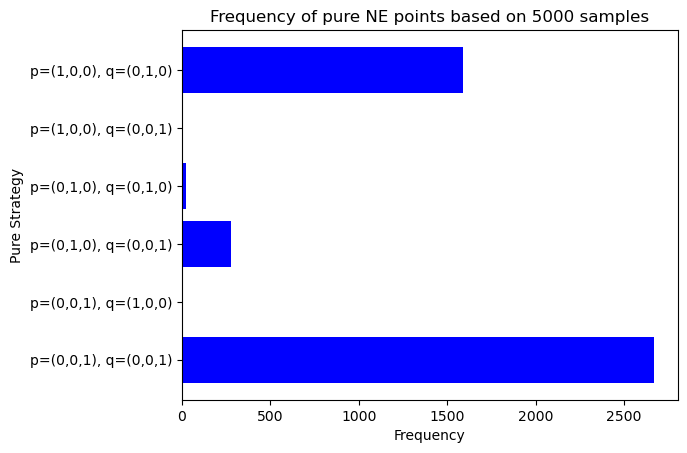

In [26]:
plot_sampleset3(sampleset=sampleset3, num_sample=5000)

In [ ]:
# sampling parameters
start = 500
end= 5001
step = 500

#paste the device arn
time_inQPU2000q, time_sampling2000q, total_runtime2000q = performance(device_arn='.../DW_2000Q_6', num_sample=[start, end], iter_step=step)
time_inQPUadvantage, time_samplingadvantage, total_runtimeadvantage = performance(device_arn='.../Advantage_system4', num_sample=[start, end], iter_step=step)

x = [sample for sample in range(start, end, step) ]

# plot QPU Time
plt.plot(x, time_inQPU2000q, color='blue', marker='o', label='DWave 2000Q 6')
plt.plot(x, time_inQPUadvantage, color='orange', marker='o', label='DWave Advantage System 4.1')
plt.title('DWave QPU Time')
plt.xlabel('Number of samples')
plt.ylabel('Time, microseconds')
plt.legend(loc="upper left")
# plt.savefig('QPU_Time_2strategies.png', dpi=600)
plt.savefig('QPU_Time_3strategies.png', dpi=600)
plt.show()

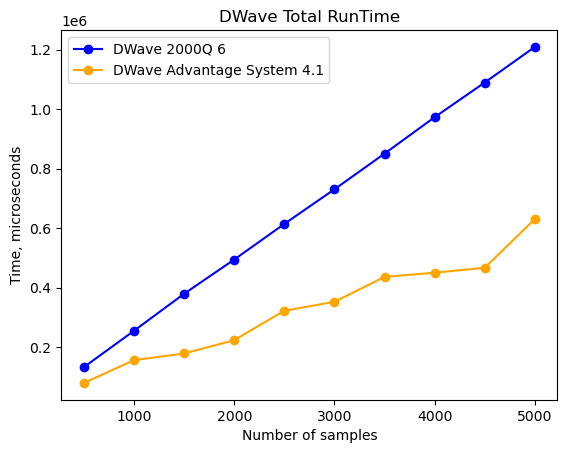

In [30]:
# Plot Total Run time
plt.plot(x, total_runtime2000q, color='blue', marker='o', label='DWave 2000Q 6')
plt.plot(x, total_runtimeadvantage, color='orange', marker='o', label='DWave Advantage System 4.1')
plt.title('DWave Total RunTime')
plt.xlabel('Number of samples')
plt.ylabel('Time, microseconds')
plt.legend(loc="upper left")
# plt.savefig('Total_Runtime_2strategies.png', dpi=600)
plt.savefig('Total_Runtime_3strategies.png', dpi=600)
plt.show()

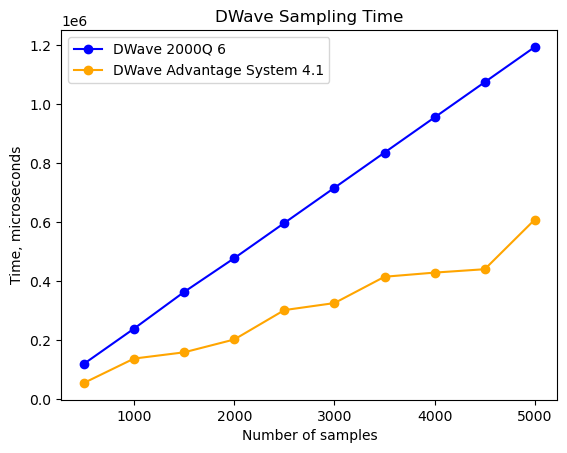

In [31]:
# plot total sampling time

plt.plot(x, time_sampling2000q, color='blue', marker='o', label='DWave 2000Q 6')
plt.plot(x, time_samplingadvantage, color='orange', marker='o', label='DWave Advantage System 4.1')
plt.title('DWave Sampling Time')
plt.xlabel('Number of samples')
plt.ylabel('Time, microseconds')
plt.legend(loc="upper left")
# plt.savefig('Sampling_Time_2strategies.png', dpi=600)
plt.savefig('Sampling_Time_3strategies.png', dpi=600)
plt.show()